In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
# Define dataset parameters
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50

In [3]:
# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
# Split the dataset into training, validation, and test sets
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [5]:
# Preprocess the data for ResNet
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0 / 255)
])

train_ds = train_ds.map(lambda x, y: (resize_and_rescale(data_augmentation(x)), y))
val_ds = val_ds.map(lambda x, y: (resize_and_rescale(x), y))
test_ds = test_ds.map(lambda x, y: (resize_and_rescale(x), y))

In [6]:
# Define and build the ResNet model
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    pooling='avg',
    classes=len(dataset.class_names)
)

for layer in base_model.layers:
    layer.trainable = False

resnet_model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(dataset.class_names), activation='softmax')
])

94765736/94765736 [==============================] - 56s 1us/step


In [7]:
# Compile the ResNet model
resnet_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [8]:
# Train the ResNet model
history_resnet = resnet_model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)


Epoch 1/50
54/54 [==============================] - 206s 4s/step - loss: 0.8979 - accuracy: 0.5305 - val_loss: 0.7907 - val_accuracy: 0.7135
Epoch 2/50
54/54 [==============================] - 199s 4s/step - loss: 0.7569 - accuracy: 0.6890 - val_loss: 0.6881 - val_accuracy: 0.7381
Epoch 3/50
54/54 [==============================] - 204s 4s/step - loss: 0.7001 - accuracy: 0.7292 - val_loss: 0.6481 - val_accuracy: 0.7552
Epoch 4/50
54/54 [==============================] - 201s 4s/step - loss: 0.7010 - accuracy: 0.7036 - val_loss: 0.6320 - val_accuracy: 0.7708
Epoch 5/50
54/54 [==============================] - 200s 4s/step - loss: 0.6716 - accuracy: 0.7342 - val_loss: 0.6507 - val_accuracy: 0.7396
Epoch 6/50
54/54 [==============================] - 200s 4s/step - loss: 0.6258 - accuracy: 0.7653 - val_loss: 0.6587 - val_accuracy: 0.7083
Epoch 7/50
54/54 [==============================] - 201s 4s/step - loss: 0.5958 - accuracy: 0.7758 - val_loss: 0.5830 - val_accuracy: 0.7865
Epoch 8/50
54

In [9]:
# Evaluate the ResNet model on the test set
resnet_scores = resnet_model.evaluate(test_ds)

8/8 [==============================] - 28s 3s/step - loss: 0.6060 - accuracy: 0.8008


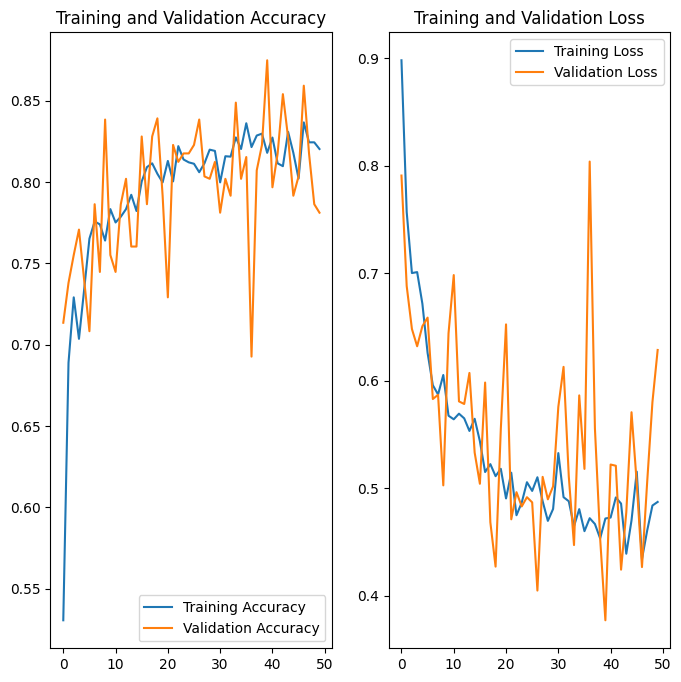

In [10]:
# Visualize training and validation curves for the ResNet model
resnet_acc = history_resnet.history['accuracy']
resnet_val_acc = history_resnet.history['val_accuracy']

resnet_loss = history_resnet.history['loss']
resnet_val_loss = history_resnet.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), resnet_acc, label='Training Accuracy')
plt.plot(range(EPOCHS), resnet_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), resnet_loss, label='Training Loss')
plt.plot(range(EPOCHS), resnet_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
# Print evaluation scores for the ResNet model
print("Test Loss:", resnet_scores[0])
print("Test Accuracy:", resnet_scores[1])

Test Loss: 0.6060327887535095
Test Accuracy: 0.80078125
